# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

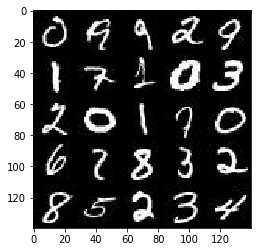

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

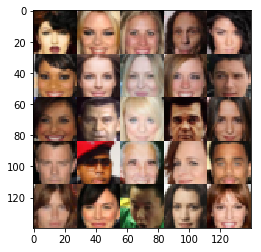

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image_input = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name="image_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return image_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
# define leaky relu func
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x, alpha * x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # reuse variable
    with tf.variable_scope("discriminator", reuse=reuse):
        # input shape (28,28,?)
        c1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        c1 = leaky_relu(c1)
        # conv1 shape (14,14,64)
    
        c2 = tf.layers.conv2d(c1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = leaky_relu(c2)
        # conv2 shape (7,7,128)
                
        c3 = tf.layers.conv2d(c2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        c3 = tf.layers.batch_normalization(c3, training=True)
        c3 = leaky_relu(c3)
        # conv2 shape (4,4,256)
        
        # Flatten it
        flat = tf.reshape(c3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)     
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha =  0.1
    
    with tf.variable_scope("generator", reuse=not is_train):
        # fully connect
        x1 = tf.layers.dense(z, 7*7*512)
        # reshape it to start conv stack
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # (7,7,16*out_channel_dim)
        
        # conv layer
        c1 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same", activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        c1 = tf.layers.batch_normalization(c1, training=is_train)
        c1 = leaky_relu(c1)
        # (14,14,256)
        
        # conv layer
        c2 = tf.layers.conv2d_transpose(c1, 128, 5, strides=2, padding="same", activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        c2 = tf.layers.batch_normalization(c2, training=is_train)
        c2 = leaky_relu(c2)
        # (28,28,128)
        
        # output layer
        logits = tf.layers.conv2d_transpose(c2, out_channel_dim, 5, strides=1, padding="same", activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # (28,28,out_channel_dim)
        
        output = tf.tanh(logits)    
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # hyper-param
    smooth = 0.1
    
    # generator net
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    
    # discriminator net
    real_output, real_logits = discriminator(input_real, False)
    fake_output, fake_logits = discriminator(input_fake, True)   
    
    # labels
    label_real = tf.ones_like(real_output)*(1-smooth)
    label_fake = tf.zeros_like(real_output)
    
    # discriminator loss function
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=label_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=label_fake))
    d_loss = d_loss_real+d_loss_fake
    
    # generator loss function
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [d for d in t_vars if d.name.startswith("discriminator")]
    g_vars = [g for g in t_vars if g.name.startswith("generator")]
    
    # discriminator optimizer
    d_model = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    # generator optimizer
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    with tf.control_dependencies(gen_updates):
        g_model = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_model, g_model


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param lr: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    
    image_input, z_input, learning_rate =model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(image_input, z_input, image_channels)
    d_model, g_model = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                i += 1
                
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # run optimizer
                sess.run(d_model, feed_dict={image_input: batch_images, z_input: batch_z, learning_rate: lr})
                sess.run(g_model, feed_dict={z_input: batch_z, learning_rate: lr})
                
                if i%100==0:
                    show_generator_output(sess, 10, z_input, image_channels, data_image_mode)
                    
                # At each epoch, get the losses and print them out
                train_loss_d = sess.run(d_loss, {z_input: batch_z, image_input: batch_images})
                train_loss_g = g_loss.eval({z_input: batch_z})
                if i%100==0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)) 
                losses.append((train_loss_d, train_loss_g))# Save losses to view after training
                
        # plot loss value
        losses = np.array(losses)
        plt.plot(losses.T[0], label='Discriminator')
        plt.plot(losses.T[1], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        plt.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

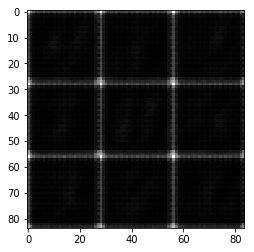

Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 1.0472


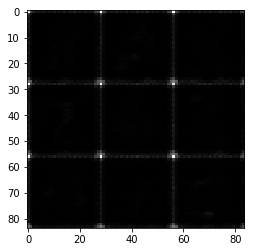

Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.7645


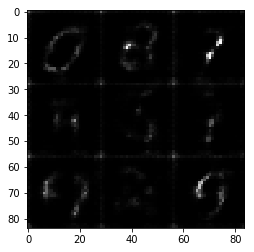

Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.5299


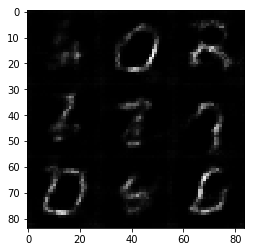

Epoch 1/2... Discriminator Loss: 1.1937... Generator Loss: 0.7262


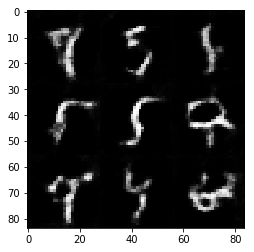

Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 0.7812


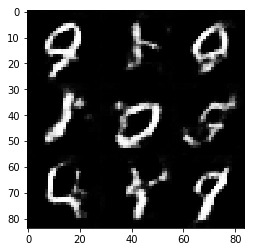

Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 1.1958


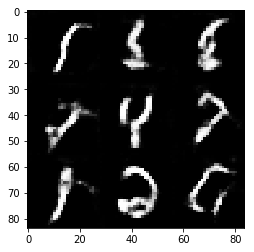

Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 1.6502


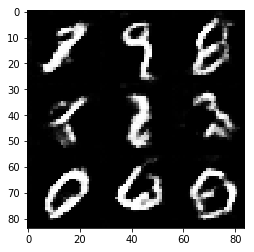

Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 0.7850


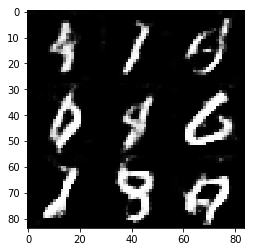

Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 1.0326


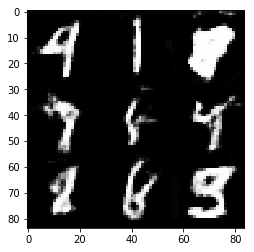

Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.6513


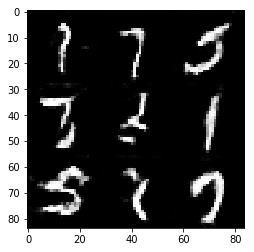

Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 0.6609


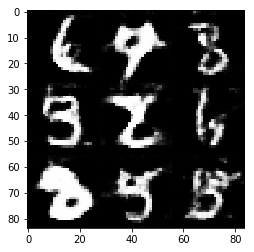

Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 0.9646


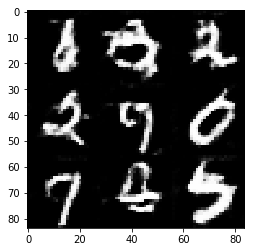

Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 1.0205


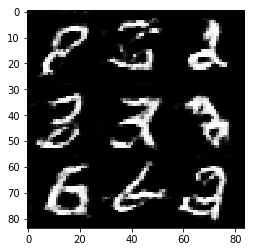

Epoch 2/2... Discriminator Loss: 0.9551... Generator Loss: 1.1274


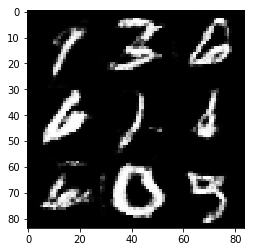

Epoch 2/2... Discriminator Loss: 0.9984... Generator Loss: 0.8331


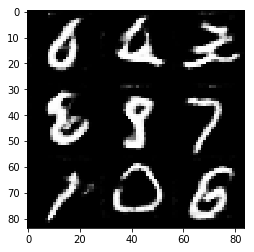

Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 1.2762


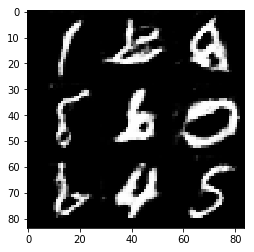

Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 1.0696


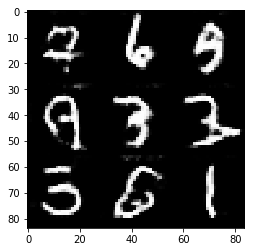

Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 0.9333


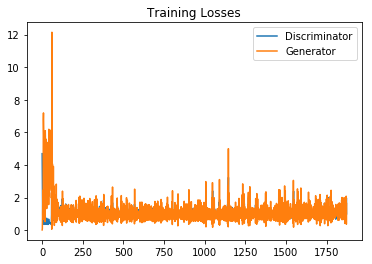

In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5 # refer to http://sebastianruder.com/optimizing-gradient-descent/index.html#adam


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

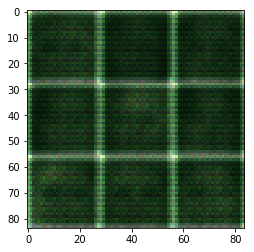

Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 2.6197


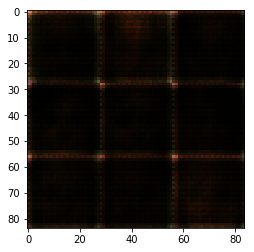

Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 3.5234


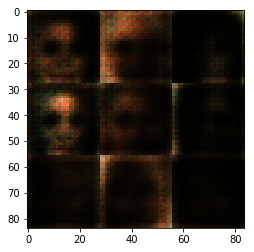

Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 2.5984


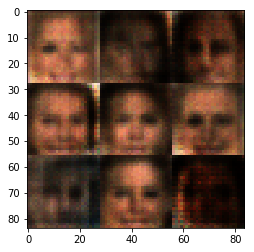

Epoch 1/1... Discriminator Loss: 1.8563... Generator Loss: 0.3522


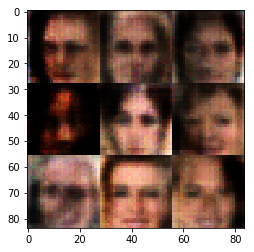

Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.0938


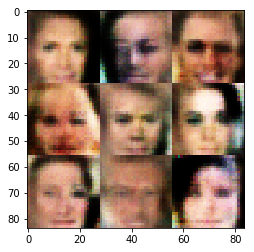

Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.8889


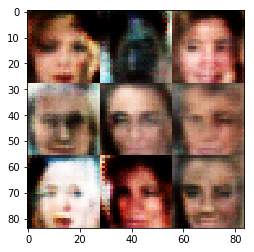

Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 2.7876


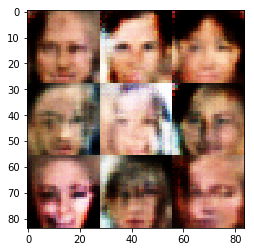

Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 3.6359


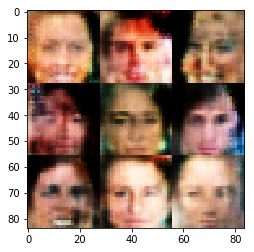

Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 2.4817


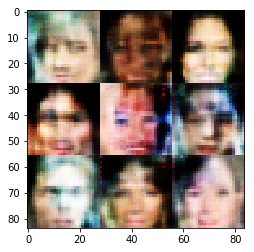

Epoch 1/1... Discriminator Loss: 0.4620... Generator Loss: 3.1381


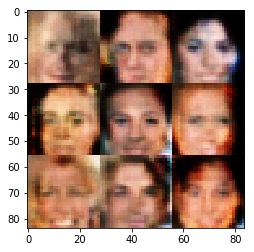

Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 3.2323


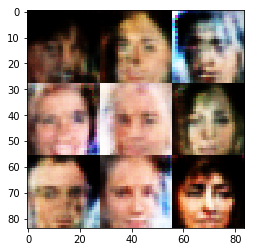

Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 4.2642


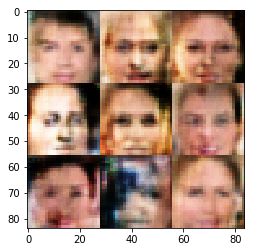

Epoch 1/1... Discriminator Loss: 1.8057... Generator Loss: 0.3219


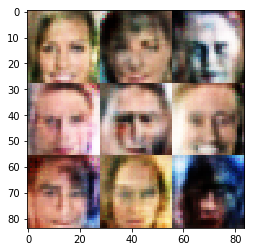

Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 2.9302


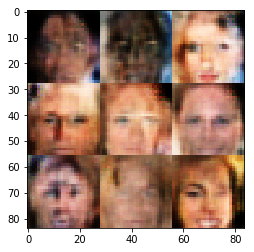

Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 1.9334


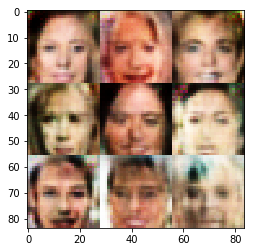

Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.4208


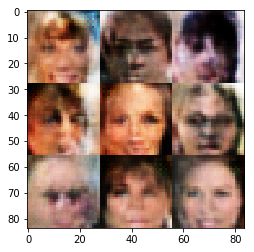

Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 2.6957


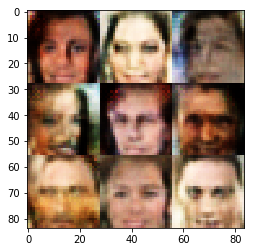

Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.5615


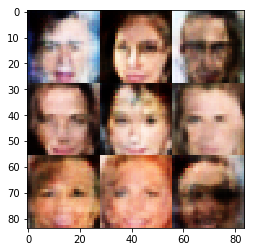

Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.5422


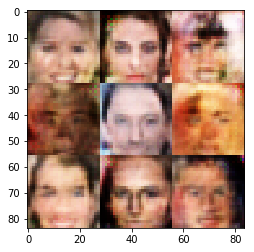

Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 3.3290


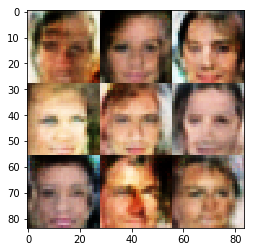

Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.1166


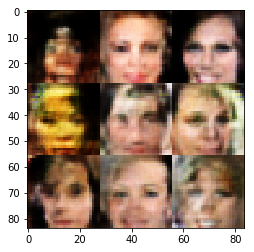

Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.6848


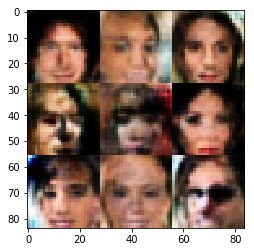

Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 1.6188


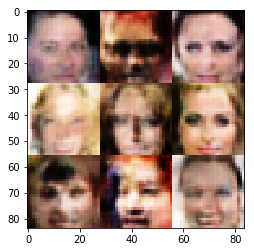

Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 1.9616


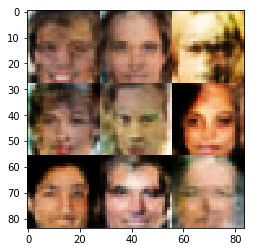

Epoch 1/1... Discriminator Loss: 1.7956... Generator Loss: 0.3788


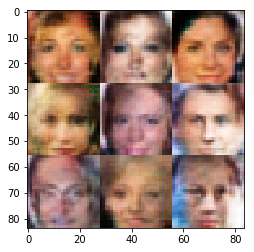

Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 1.9672


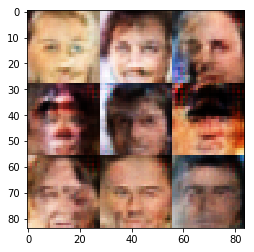

Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 2.4998


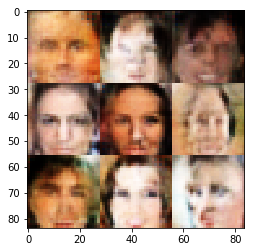

Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.1466


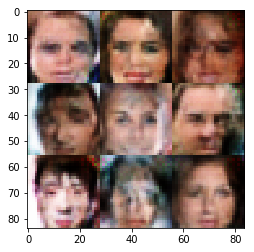

Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.8816


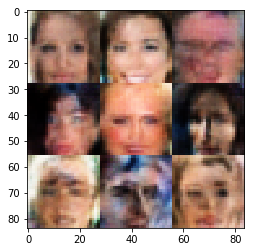

Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 1.6162


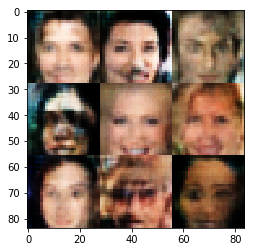

Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.0348


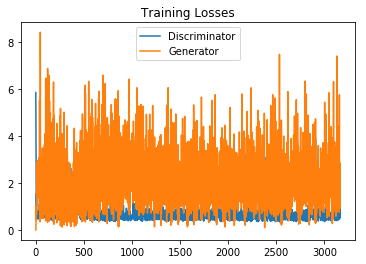

In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5 # refer to http://sebastianruder.com/optimizing-gradient-descent/index.html#adam


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.